**Install requirements**

In [ ]:
!pip install segmentation-models-pytorch
!pip install torchmetrics
!pip install fvcore
!pip install ptflops

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 10.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=d5d6efb5a51d6276c280b58a535066d7dce423bd7a31a610838c993b6670ceeb
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=cb392d1a188ee78ada41d1dbae5e65008ae927afc6f426eb4cd78466833ac9e7
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 k

**Import libraries**

In [ ]:
import os
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import jaccard_score

import time

from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# **Global variables**

In [ ]:
NUM_CLASSES = 7

BATCH_SIZE = 32     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                    # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.01             # The initial Learning Rate
MOMENTUM = 0.9        # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0001 # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)


LR_D=0.005
WEIGHT_DECAY_DISC = 0.0001
# Initial configuration for LAMBDA_ADV
LAMBDA_ADV = 0.005  # Initial value
LAMBDA_ADV_MAX = 0.05  # Maximum value
LAMBDA_ADV_STEP = (LAMBDA_ADV_MAX - LAMBDA_ADV) / NUM_EPOCHS  # Increment per epoch

STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1             # Multiplicative factor for learning rate step-down

# **Dataset management**

In [ ]:
#'''
#1yzLCHM-BHGaEvt5DqnCBzaLfLF-qOQ7M
if not os.path.isdir('/content/LoveDA'):
  # Download the LoveDA dataset if it doesn't exist in the directory
  !gdown --id 1yzLCHM-BHGaEvt5DqnCBzaLfLF-qOQ7M # Estimated time: 3-5 minutes
  !jar xvf  "/content/LoveDA.zip" # Extract the file

# Check if the dataset was copied correctly
if not os.path.isdir('/content/LoveDA'):
    print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/PIDNet_S_ImageNet.pth.tar"):
  !gdown --id 1reDp2XdraXqPHXvmZvIXzXN8lrTphPk8

if not os.path.isfile("/content/best_model_adversarial_optWL_multiStepLR.pth"):
  !gdown --id 1kBi8dPU5_ez7I_xKp_CrOzLqwDKZGKY0

# Utilities
if not os.path.isfile("/content/model_utils.py"):
    # Download the model_utils.py script
    !gdown --id 1Uq3E3F6fO7qXInkS2IFGHS5WDxrrNSpr
'''

# OPTION 2
# Download LoveDA train an val dataset, from https://zenodo.org/records/5706578, extract and put them in a unique folder: LoveDA
# Download the Utils folder from github: https://github.com/Zafonte/Real-time-Domain-Adaptation-in-Semantic-Segmentation.git
# Upload in your drive the dataset and the Utils folder - then run the following line of code
from google.colab import drive
drive.mount('/content/drive')

# Copy the dataset from your Google Drive folder to /content
if not os.path.isdir('/content/LoveDA'):
    !cp -r "/content/drive/MyDrive/AMLProjectCode/LoveDA" /content/                        #PUT your path

# Check if the dataset has been copied correctly
if not os.path.isdir('/content/LoveDA'):
    print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/PIDNet_S_ImageNet.pth.tar"):
  !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/PIDNet_S_ImageNet.pth.tar" /content/  #PUT your path

if not os.path.isfile("/content/best_model_adversarial_optWL_multiStepLR.pth"):
  !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/best_model_adversarial_optWL_multiStepLR.pth" /content/     #PUT your path

# Utilities
if not os.path.isfile("/content/model_utils.py"):
    !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/model_utils.py" /content/           #PUT your path

'''


Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/AMLProjectCode/Utils/best_model_adversarial_optWL_multiStepLR.pth': No such file or directory


**LoveDA dataset class**


In [ ]:
COLOR_MAP = OrderedDict(
    Black = (0, 0, 0),
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(0, 255, 0),
    Agricultural=(255, 195, 128),
)


LABEL_MAP = OrderedDict(
    Black = -1,
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)


def map_labels(label):
    mapped_label = np.where(label == 0, -1, np.where(label >= 1, label - 1, label)) # Change pixel values
    return torch.tensor(mapped_label, dtype=torch.long)


class LoveDADataset(Dataset):
    def __init__(self, images_path, masks_path, image_transform=None, mask_transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted([f for f in os.listdir(images_path) if f.endswith('.png')])
        self.masks = sorted([f for f in os.listdir(masks_path) if f.endswith('.png')])

        # Check if the number of images matches the number of masks
        if len(self.images) != len(self.masks):
            raise ValueError("The number of images and masks does not match!")

    def __getitem__(self, idx):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target)
        '''
        # Read image and mask
        image = Image.open(os.path.join(self.images_path, self.images[idx])).convert('RGB')
        mask = Image.open(os.path.join(self.masks_path, self.masks[idx]))

        # Apply transformation to images (if present)
        if self.image_transform:
            image = self.image_transform(image)

        # Apply transformation to masks (if present)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Convert mask to NumPy array for mapping
        mask_np = np.array(mask, dtype=np.int64)

        # Map labels using map_labels function
        mask_mapped = map_labels(mask_np)

        return image, mask_mapped

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        return len(self.images)


# **Network setup**

**PIDNet**: a real-time segmentation network

In [ ]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import sys
import os

from model_utils import BasicBlock, Bottleneck, segmenthead, DAPPM, PAPPM, PagFM, Bag, Light_Bag

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch - extracts main features at reduced resolutions
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch - optimized for scene parsing
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch - captures fine details (edges, contours)
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        print('PIDNet-S backbone pretraining on ImageNet loading...')
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
        print('PIDNet-S backbone pretraining on ImageNet LOADED')
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model


In [ ]:
# Configurazione con il percorso al file pre-addestrato
class Config:
    class MODEL:
        NAME = 's'  # Specifica il modello ('s', 'm', etc.)
        PRETRAINED = '/content/PIDNet_S_ImageNet.pth.tar'  # Percorso al file PIDNet_S pretrainato on ImageNet

    class DATASET:
        NUM_CLASSES = NUM_CLASSES  # Numero di classi del dataset


**Visualize prediction function**

In [ ]:
def visualize_prediction(image, true_mask, pred_mask):
    """
    Visualizes the original image, true mask, and predicted mask.
    Parameters:
    - image: Tensor image (C, H, W).
    - true_mask: Tensor true mask.
    - pred_mask: Tensor predicted mask.
    """

    print("Comparing true mask and prediction for a sample train image:")

    # Define ImageNet mean and standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = image.cpu().numpy().transpose(1, 2, 0)  # Change image shape for matplotlib

    # If the image has been normalized for the model, we need to de-normalize it
    # De-normalize the image
    image = image * std + mean  # Inverse normalization
    image = np.clip(image, 0, 1)  # Ensure values are in the range [0, 1]

    # Convert image and labels into numpy arrays for visualization
    true_mask_np = np.array(true_mask.cpu(), dtype=np.int64)
    pred_mask_np = np.array(pred_mask.cpu(), dtype=np.int64)

    # Create a colored mask based on LABEL_MAP and COLOR_MAP
    colored_true_mask = np.zeros((true_mask_np.shape[0], true_mask_np.shape[1], 3), dtype=np.uint8)
    colored_pred_mask = np.zeros((pred_mask_np.shape[0], pred_mask_np.shape[1], 3), dtype=np.uint8)
    for class_name, color in COLOR_MAP.items():
        class_value = LABEL_MAP[class_name]  # Get the numeric value for the class
        colored_true_mask[true_mask_np == class_value] = color  # Apply the correct color
        colored_pred_mask[pred_mask_np == class_value] = color  # Apply the correct color

    # Create figure with subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # True mask
    ax[1].imshow(colored_true_mask)
    ax[1].set_title('True Mask')
    ax[1].axis('off')
    print(f"Unique values (mapped) in true mask: {np.unique(true_mask_np)}")

    # Predicted mask
    ax[2].imshow(colored_pred_mask)
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    print(f"Unique values in predicted mask: {np.unique(pred_mask_np)}")
    print()

    legend_patches = [mpatches.Patch(color=np.array(color) / 255.0, label=class_name) for class_name, color in COLOR_MAP.items()]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    # Show the image
    plt.show()


# **Define Data Preprocessing**

In [ ]:
## images transformation
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(), # Turn PIL Image to torch.Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization - Pre-trained models on ImageNet (such as ResNet101 for DeepLabV2 and PIDNet-S) expect normalized images.
])

# masks transformation
mask_transform = transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST)

In [ ]:
import random
import torchvision.transforms.functional as TF
import torchvision.transforms as T

# Definition of data augmentation transformations
class DataAugmentation:
    def __init__(self, probability=0.5):
        self.probability = probability
        self.transforms = [
            self.horizontal_flip
        ]

    def __call__(self, image, mask):
        if random.random() < self.probability:
            for transform in self.transforms:
                image, mask = transform(image, mask)
        return image, mask if mask is not None else torch.empty(0)  # Returns an empty mask if `mask` is `None`

    def horizontal_flip(self, image, mask):
        """Horizontal flip."""
        image = TF.hflip(image)
        mask = TF.hflip(mask)
        return image, mask

    def gaussian_blur(self, image, mask):
        """Gaussian blur with a random radius between 1 and 3."""
        # GaussianBlur is a filter that smoothens an image by applying a Gaussian kernel. It's used to reduce details or noise in an image.
        # In data augmentation, it's used to simulate scenarios where the image might appear less defined,
        # such as in the presence of fog, lens blur, or limited visibility.
        blur = T.GaussianBlur(kernel_size=(5, 5), sigma=(1, 3))
        return blur(image), mask

    def multiply(self, image, mask):
        """Random brightness adjustment with a factor between 0.7-1.3."""
        factor = random.uniform(0.7, 1.3)  # Random multiplication factor
        return image * factor, mask

    def vertical_flip(self, image, mask):
        """Vertical flip."""
        return TF.vflip(image), TF.vflip(mask)


# **Dataset object**

In [ ]:
from torch.utils.data import Subset

train_dataset_source = LoveDADataset(
    "/content/LoveDA/Train/Urban/images_png",
    "/content/LoveDA/Train/Urban/masks_png",
    image_transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = LoveDADataset(
    "/content/LoveDA/Val/Rural/images_png",
    "/content/LoveDA/Val/Rural/masks_png",
    image_transform=image_transform,
    mask_transform=mask_transform
)

train_dataset_target = LoveDADataset(
    "/content/LoveDA/Train/Rural/images_png",
    "/content/LoveDA/Train/Rural/masks_png",
    image_transform=image_transform,
    mask_transform=mask_transform
)

# Stampa per verificare
print(f"Number of images into train dataset: {len(train_dataset_source)}")
print(f"Number of images into target dataset: {len(train_dataset_target)}")

Number of images into train dataset: 1156
Number of images into target dataset: 1366


# **Dataloaders**

In [ ]:
#DataLoader
train_loader_source = DataLoader(train_dataset_source, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
train_loader_target = DataLoader(train_dataset_target, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# **Prepare Network**

In [ ]:
# Create configuration object
cfg = Config()

# Get the model with pretrained weights from ImageNet
model = get_seg_model(cfg, imgnet_pretrained = True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

PIDNet-S backbone pretraining on ImageNet loading...


<ipython-input-7-58ed1a78170c>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


PIDNet-S backbone pretraining on ImageNet LOADED


# Class **weights**

In [ ]:
import numpy as np
import torch

def calculate_class_weights(device=device):
    """
    Calcola i pesi delle classi inversamente proporzionali alla loro frequenza nel dataset.

    Argomenti:
    set di dati (Dataset): Il dataset di riferimento.
    num_classes (int): Numero totale di classi.
    dispositivo (str): Dispositivo su cui calcolare i pesi.

    Resi:
    torcia.Tensore: Tensore contenente i pesi per ciascuna classe.
    """
    num_classes = NUM_CLASSES
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0

    for _, mask in tqdm(train_loader_source, desc="Computation of the weights of each class"):
        mask = mask.to(device).squeeze(0)
        for cls in range(num_classes):
            class_counts[cls] += torch.sum(mask == cls)
        total_pixels += mask.numel()

    # To avoid division by zero
    class_freq = class_counts / total_pixels
    class_weights = 1.0 / (class_freq + 1e-6)

    # Normalization of the weights
    class_weights = class_weights / class_weights.sum() * num_classes

    return class_weights, class_freq

weights, class_freq = calculate_class_weights()
print(weights, class_freq)

Computation of the weights of each class: 100%|██████████| 36/36 [01:14<00:00,  2.07s/it]


tensor([0.1165, 0.2667, 0.6076, 1.5084, 0.7536, 0.7117, 3.0354],
       device='cuda:0') tensor([0.4614, 0.2016, 0.0885, 0.0356, 0.0713, 0.0755, 0.0177],
       device='cuda:0')


In [ ]:
weights = torch.tensor([0.3, 0.5, 0.8, 1.4, 1.2, 1.2, 1.6]).to('cuda')

# **Validation setup**

In [ ]:
LABEL = {
    'Background': 0,
    'Building': 1,
    'Road': 2,
    'Water': 3,
    'Barren': 4,
    'Forest': 5,
    'Agricultural': 6
}

# Function to calculate confusion matrix
# a: ground truth, b: predictions, n: number of classes
def fast_hist(a, b, n):
    """
    Calculate a confusion matrix between classes.

    Args:
        a (np.array): Ground truth (1D or 2D array).
        b (np.array): Prediction (1D or 2D array).
        n (int): Number of classes.

    Returns:
        np.array: Confusion matrix of size n x n.
    """
    # Create a boolean index for valid values
    k = (a >= 0) & (a < n)

    # Compute confusion matrix
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

# Function to calculate IoU per class
def per_class_iou(hist):
    epsilon = 1e-5  # Small constant to avoid division by zero
    # intersection = values on the diagonal of the confusion matrix
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

# Function to compute mIoU on a validation set
def compute_mIoU(model, val_loader, num_classes, device):
    model.eval()
    hist = np.zeros((num_classes, num_classes))

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            # Resize the predicted mask to (512, 512)
            outputs_resized = torch.nn.functional.interpolate(
                outputs,
                size=(512, 512),
                mode='bilinear'
            )

            preds = torch.argmax(outputs_resized, dim=1) # Predicted class

            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            for lt, lp in zip(masks, preds):
                hist += fast_hist(lt.flatten(), lp.flatten(), num_classes)

    iou = per_class_iou(hist)
    mIoU = np.mean(iou)

    # Print IoU for each class with class names
    print("IoU per category (%):")
    for class_idx in range(num_classes):
        class_name = list(LABEL.keys())[list(LABEL.values()).index(class_idx)]
        print(f" {class_name}: {iou[class_idx] * 100:.2f}%")
    print()

    print(f"mIoU: {mIoU * 100:.2f}%")
    print()
    return mIoU


# **Adversarial approach**

# Discriminator

In [ ]:
class DepthWiseSeparableConvolution(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(DepthWiseSeparableConvolution, self).__init__()
        self.depth_wise = nn.Conv2d(ch_in, ch_in, kernel_size=4, stride=2, padding=1, groups=ch_in)
        self.point_wise = nn.Conv2d(ch_in, ch_out, kernel_size=1)

    def forward(self, x):
        out = self.depth_wise(x)
        out = self.point_wise(out)
        return out

class LightFCDiscriminator(nn.Module):
    def __init__(self, num_classes, ndf=64):
        super(LightFCDiscriminator, self).__init__()

        # context
        self.conv1 = DepthWiseSeparableConvolution(num_classes, ndf)
        self.conv2 = DepthWiseSeparableConvolution(ndf, ndf*2)
        self.conv3 = DepthWiseSeparableConvolution(ndf*2, ndf*4)
        self.conv4 = DepthWiseSeparableConvolution(ndf*4, ndf*8)
        self.classifier = DepthWiseSeparableConvolution(ndf*8, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.up_sample = nn.Upsample(scale_factor=32, mode='bilinear')


    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = self.classifier(x)
        x = self.up_sample(x)
        return x

class LightLightFCDiscriminator(nn.Module):
    def __init__(self, num_classes, ndf=64):
        super(LightLightFCDiscriminator, self).__init__()

        # context
        self.conv1 = DepthWiseSeparableConvolution(num_classes, ndf)
        self.conv2 = DepthWiseSeparableConvolution(ndf, ndf*2)
        self.classifier = DepthWiseSeparableConvolution(ndf*2, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.up_sample = nn.Upsample(scale_factor=8, mode='bilinear')


    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.classifier(x)
        x = self.up_sample(x)
        return x

class FCDiscriminator(nn.Module):

    def __init__(self, num_classes, ndf = 64):
        super(FCDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(num_classes, ndf, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1)
        self.classifier = nn.Conv2d(ndf*8, 1, kernel_size=4, stride=2, padding=1)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.up_sample = nn.Upsample(scale_factor=32, mode='bilinear')


    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = self.classifier(x)
        x = self.up_sample(x)

        return x

# **Training**


In [ ]:
trained = True #SET to true if you want to use pretrained weights otherwise False
plot_training = False

Epoch 1/20:   0%|          | 0/1152 [00:00<?, ?it/s]<ipython-input-20-d073f4c74750>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-20-d073f4c74750>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20: 100%|██████████| 1152/1152 [02:44<00:00,  6.99it/s, Loss_G=1.3609, Loss_D=0.8472]


Epoch 1, Average Loss_G: 2.3607, Average Loss_D: 9.1695


IoU per category (%):
 Background: 30.05%
 Building: 11.77%
 Road: 12.33%
 Water: 29.14%
 Barren: 8.03%
 Forest: 8.82%
 Agricultural: 12.42%

mIoU: 16.08%

Validation mIoU after epoch 1: 0.1608
New best model saved with mIoU: 0.1608
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5 6]
Unique values in predicted mask: [0 1 2 4 5 6]



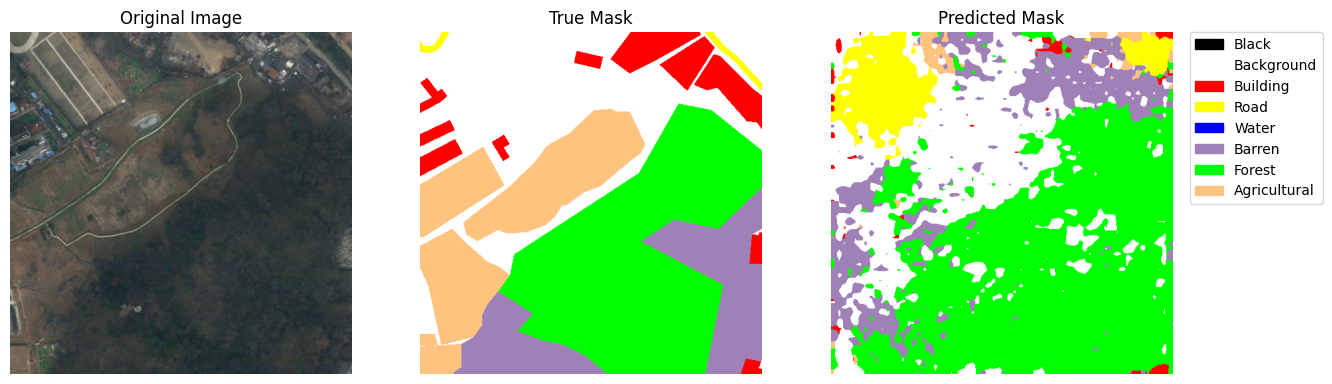

Epoch 2/20: 100%|██████████| 1152/1152 [02:44<00:00,  7.00it/s, Loss_G=1.2383, Loss_D=0.6361]


Epoch 2, Average Loss_G: 1.1899, Average Loss_D: 1.0117


IoU per category (%):
 Background: 37.07%
 Building: 12.27%
 Road: 13.29%
 Water: 27.92%
 Barren: 10.86%
 Forest: 7.13%
 Agricultural: 8.42%

mIoU: 16.71%

Validation mIoU after epoch 2: 0.1671
New best model saved with mIoU: 0.1671
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2]
Unique values in predicted mask: [0 1 2 5]



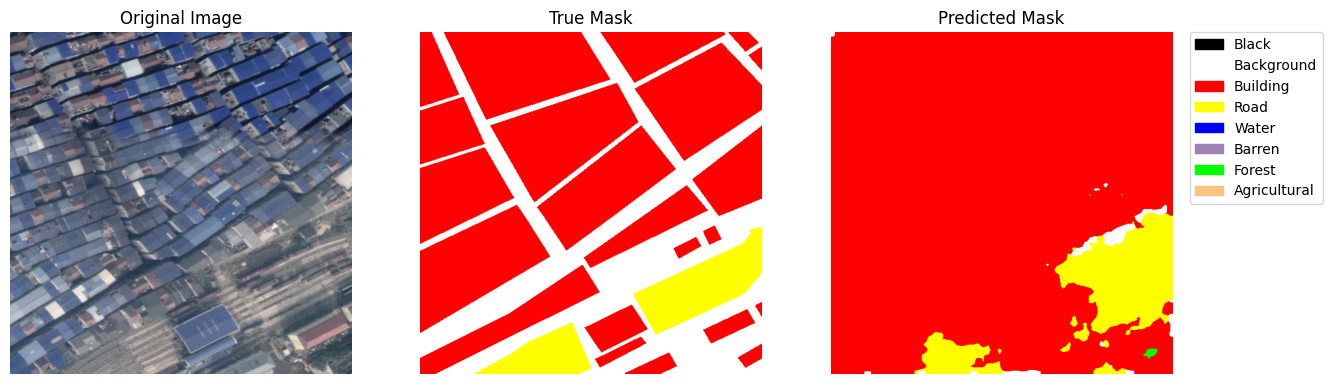

Epoch 3/20: 100%|██████████| 1152/1152 [02:43<00:00,  7.05it/s, Loss_G=0.9690, Loss_D=0.6890]


Epoch 3, Average Loss_G: 0.9651, Average Loss_D: 0.5753


IoU per category (%):
 Background: 38.60%
 Building: 14.44%
 Road: 15.22%
 Water: 32.50%
 Barren: 10.26%
 Forest: 4.83%
 Agricultural: 10.88%

mIoU: 18.10%

Validation mIoU after epoch 3: 0.1810
New best model saved with mIoU: 0.1810
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 5]
Unique values in predicted mask: [0 1 2 3 5]



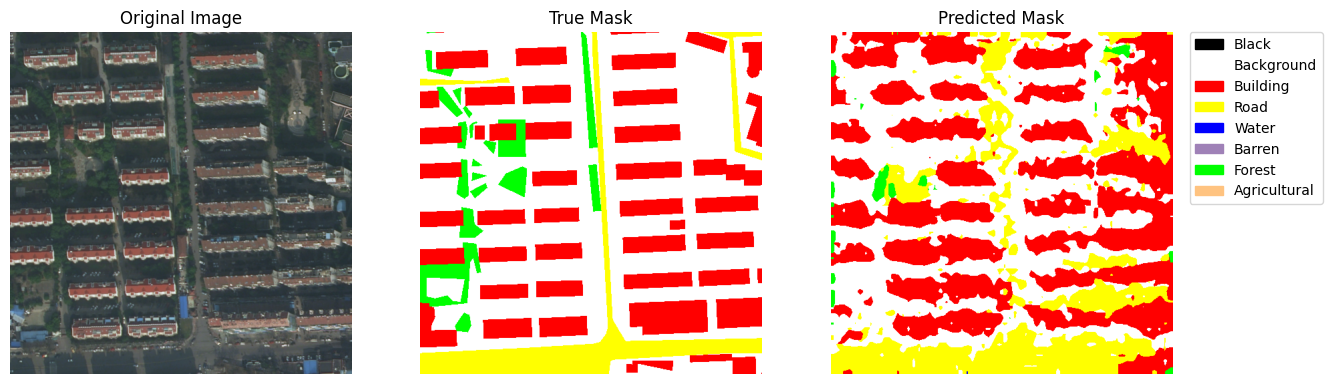

Epoch 4/20: 100%|██████████| 1152/1152 [02:40<00:00,  7.19it/s, Loss_G=0.8591, Loss_D=0.6351]


Epoch 4, Average Loss_G: 0.8627, Average Loss_D: 0.5525


IoU per category (%):
 Background: 39.09%
 Building: 13.38%
 Road: 17.17%
 Water: 32.01%
 Barren: 10.80%
 Forest: 5.22%
 Agricultural: 13.68%

mIoU: 18.76%

Validation mIoU after epoch 4: 0.1876
New best model saved with mIoU: 0.1876
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



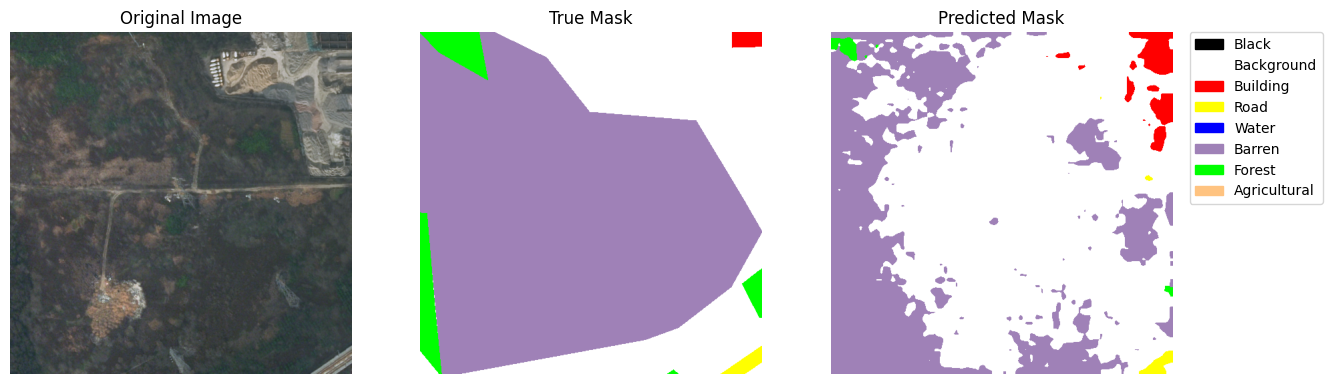

Epoch 5/20: 100%|██████████| 1152/1152 [02:42<00:00,  7.08it/s, Loss_G=0.8045, Loss_D=0.5517]


Epoch 5, Average Loss_G: 0.8053, Average Loss_D: 0.5131


IoU per category (%):
 Background: 44.19%
 Building: 21.07%
 Road: 18.67%
 Water: 33.47%
 Barren: 12.24%
 Forest: 7.24%
 Agricultural: 15.37%

mIoU: 21.75%

Validation mIoU after epoch 5: 0.2175
New best model saved with mIoU: 0.2175
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3]
Unique values in predicted mask: [0 1 2 3 4 5 6]



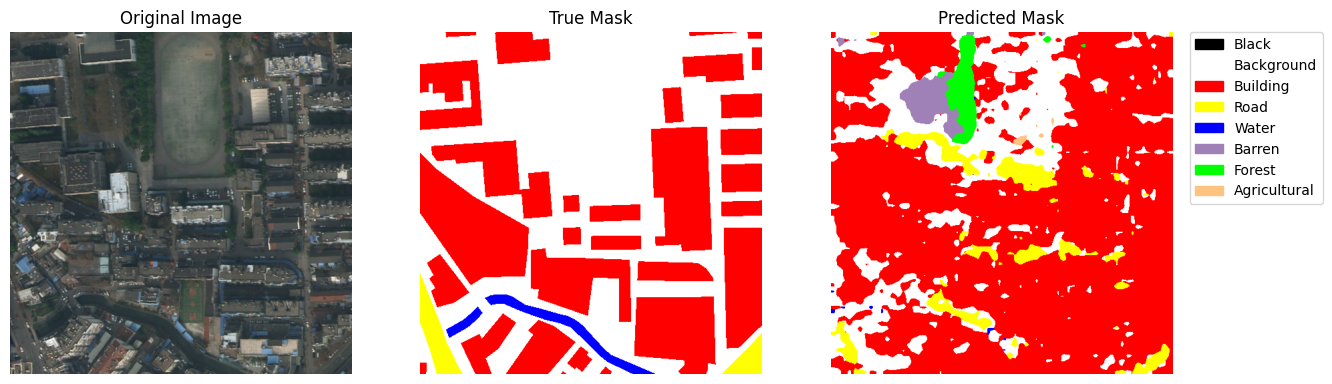

Epoch 6/20: 100%|██████████| 1152/1152 [02:44<00:00,  7.01it/s, Loss_G=0.8589, Loss_D=0.5956]


Epoch 6, Average Loss_G: 0.7644, Average Loss_D: 0.6344


IoU per category (%):
 Background: 42.20%
 Building: 19.67%
 Road: 18.28%
 Water: 34.81%
 Barren: 8.78%
 Forest: 7.45%
 Agricultural: 13.87%

mIoU: 20.72%

Validation mIoU after epoch 6: 0.2072
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 5]
Unique values in predicted mask: [0 1 2 4 5]



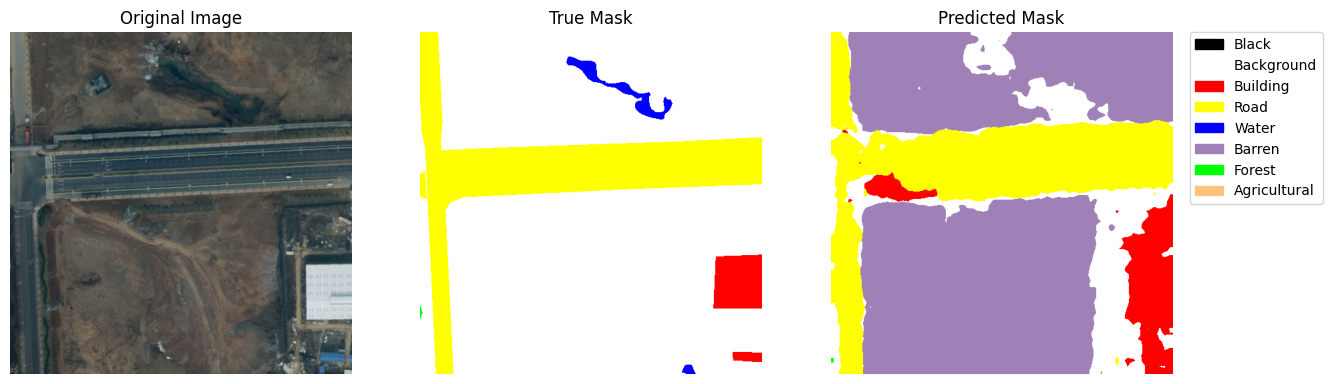

Epoch 7/20: 100%|██████████| 1152/1152 [02:44<00:00,  7.00it/s, Loss_G=0.7258, Loss_D=0.5858]


Epoch 7, Average Loss_G: 0.7290, Average Loss_D: 0.5241


IoU per category (%):
 Background: 39.18%
 Building: 17.22%
 Road: 19.19%
 Water: 35.49%
 Barren: 8.83%
 Forest: 7.37%
 Agricultural: 13.94%

mIoU: 20.17%

Validation mIoU after epoch 7: 0.2017
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2  5]
Unique values in predicted mask: [0 1 2 3 4 5]



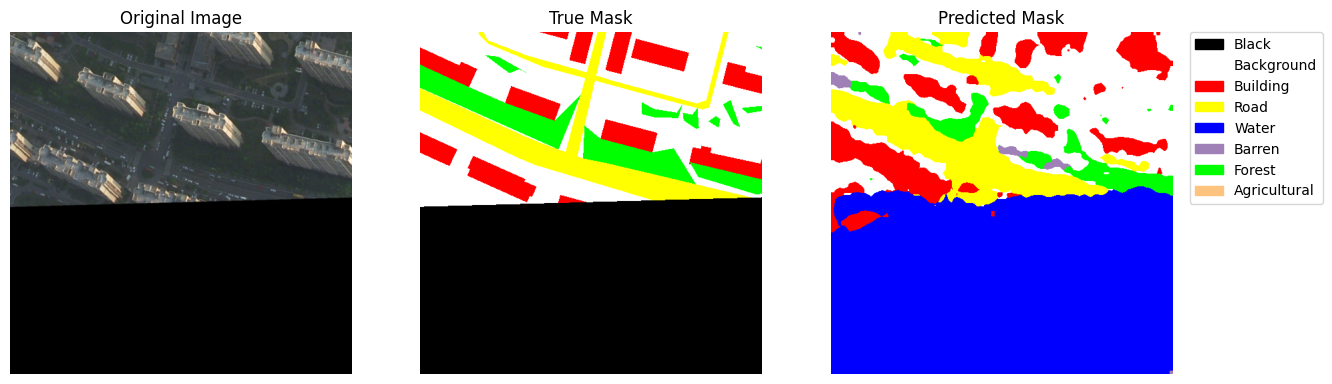

Epoch 8/20: 100%|██████████| 1152/1152 [02:42<00:00,  7.11it/s, Loss_G=0.7228, Loss_D=0.5074]


Epoch 8, Average Loss_G: 0.7212, Average Loss_D: 0.4833


IoU per category (%):
 Background: 42.49%
 Building: 20.35%
 Road: 24.55%
 Water: 32.26%
 Barren: 7.62%
 Forest: 7.62%
 Agricultural: 21.82%

mIoU: 22.39%

Validation mIoU after epoch 8: 0.2239
New best model saved with mIoU: 0.2239
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 4 5]
Unique values in predicted mask: [0 1 2 4 5]



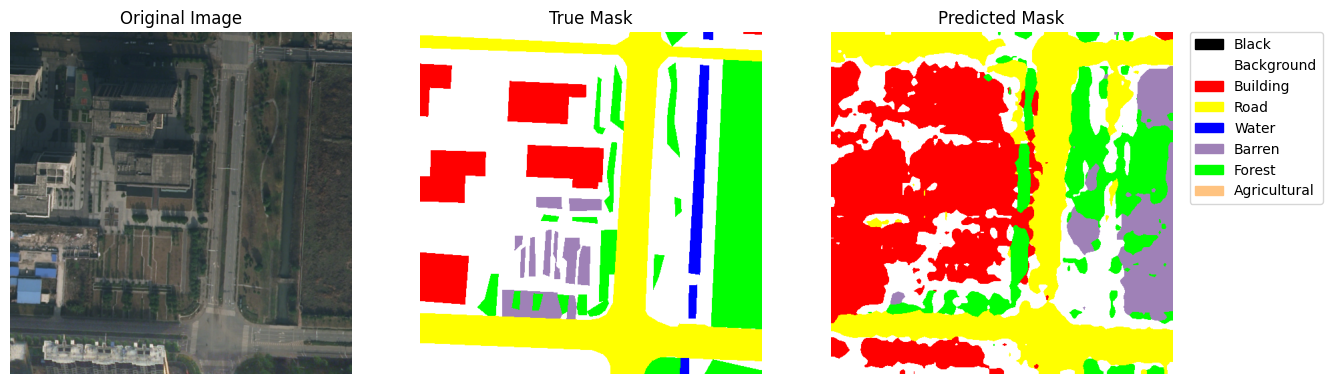

Epoch 9/20: 100%|██████████| 1152/1152 [02:40<00:00,  7.16it/s, Loss_G=0.7736, Loss_D=0.6451]


Epoch 9, Average Loss_G: 0.6849, Average Loss_D: 0.5043


IoU per category (%):
 Background: 42.47%
 Building: 20.69%
 Road: 18.51%
 Water: 39.89%
 Barren: 7.87%
 Forest: 3.64%
 Agricultural: 9.58%

mIoU: 20.38%

Validation mIoU after epoch 9: 0.2038
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 5]
Unique values in predicted mask: [0 1 2 3 4 5]



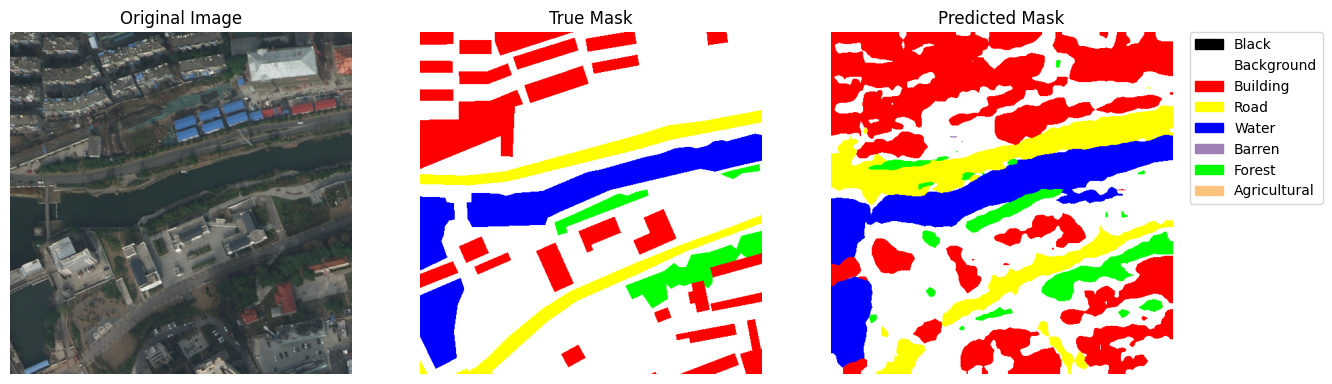

Epoch 10/20: 100%|██████████| 1152/1152 [02:44<00:00,  7.02it/s, Loss_G=0.6740, Loss_D=0.5473]


Epoch 10, Average Loss_G: 0.6704, Average Loss_D: 0.4824


IoU per category (%):
 Background: 39.96%
 Building: 20.73%
 Road: 17.96%
 Water: 31.99%
 Barren: 5.61%
 Forest: 3.52%
 Agricultural: 13.43%

mIoU: 19.03%

Validation mIoU after epoch 10: 0.1903
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2]
Unique values in predicted mask: [0 1 2 5]



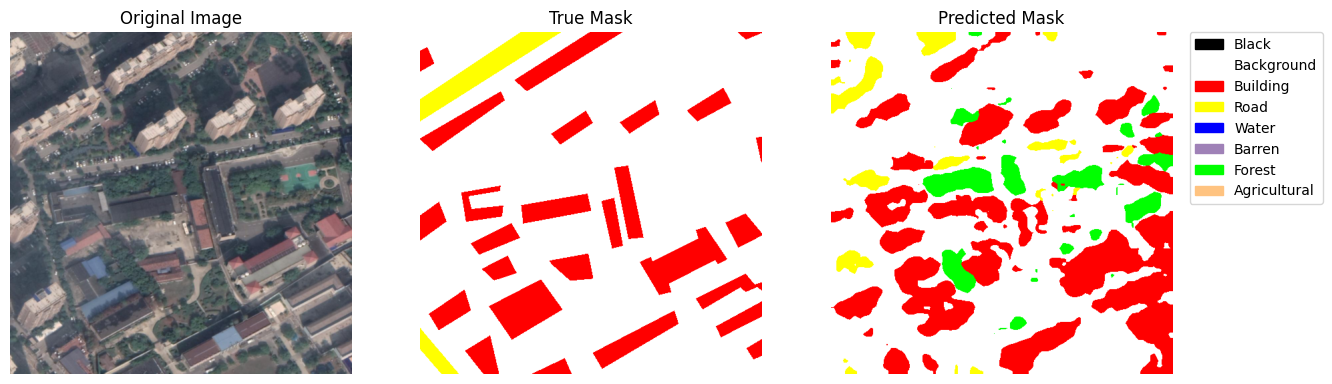

Epoch 11/20: 100%|██████████| 1152/1152 [02:43<00:00,  7.06it/s, Loss_G=0.6730, Loss_D=0.5991]


Epoch 11, Average Loss_G: 0.6516, Average Loss_D: 0.4595


IoU per category (%):
 Background: 38.30%
 Building: 21.81%
 Road: 19.08%
 Water: 30.00%
 Barren: 5.16%
 Forest: 3.40%
 Agricultural: 14.95%

mIoU: 18.96%

Validation mIoU after epoch 11: 0.1896
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 5]
Unique values in predicted mask: [0 1 2 3 5]



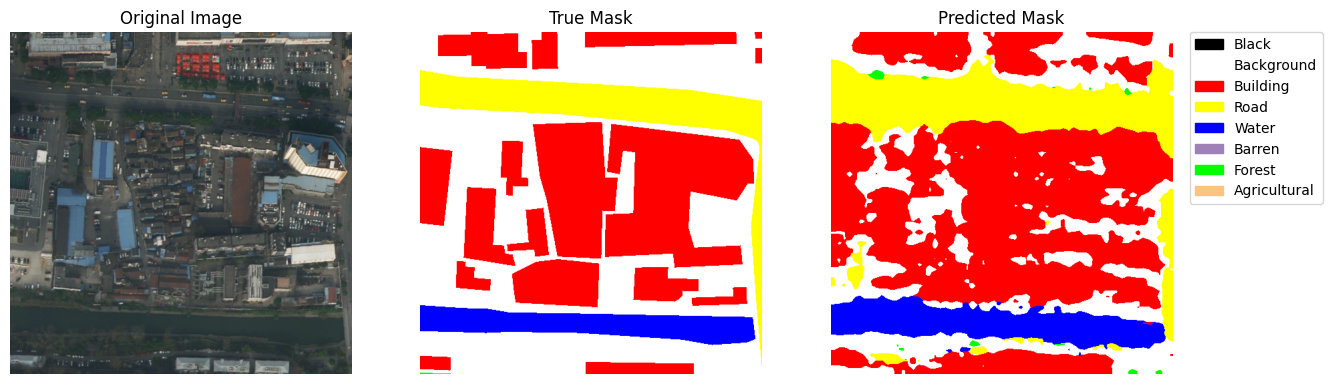

Epoch 12/20: 100%|██████████| 1152/1152 [02:40<00:00,  7.16it/s, Loss_G=0.6989, Loss_D=0.5668]


Epoch 12, Average Loss_G: 0.6203, Average Loss_D: 0.4576


IoU per category (%):
 Background: 39.38%
 Building: 23.46%
 Road: 18.62%
 Water: 34.66%
 Barren: 5.50%
 Forest: 4.66%
 Agricultural: 13.10%

mIoU: 19.91%

Validation mIoU after epoch 12: 0.1991
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5 6]
Unique values in predicted mask: [0 1 2 4 5]



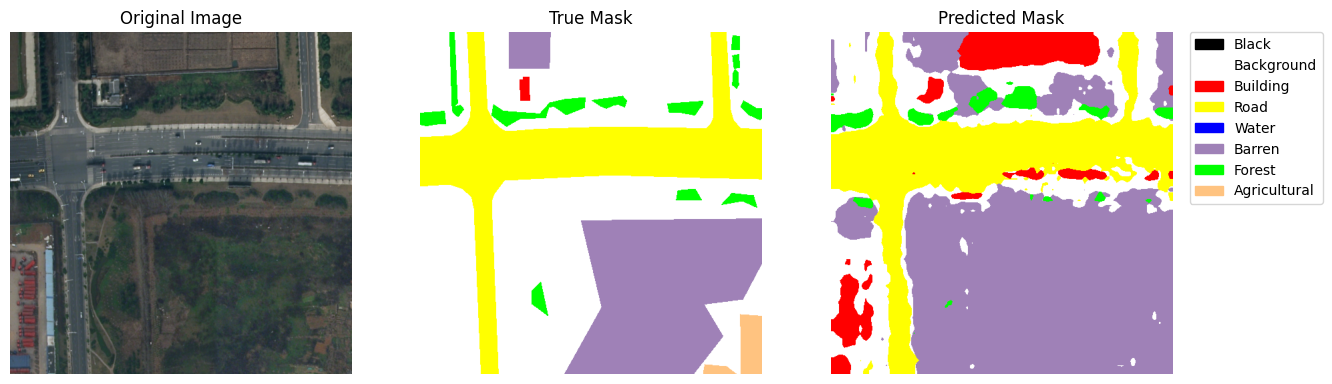

Epoch 13/20: 100%|██████████| 1152/1152 [02:44<00:00,  6.99it/s, Loss_G=0.5618, Loss_D=0.4604]


Epoch 13, Average Loss_G: 0.6239, Average Loss_D: 0.4614


IoU per category (%):
 Background: 41.31%
 Building: 23.67%
 Road: 18.53%
 Water: 33.26%
 Barren: 5.94%
 Forest: 4.99%
 Agricultural: 13.50%

mIoU: 20.17%

Validation mIoU after epoch 13: 0.2017
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 4]
Unique values in predicted mask: [0 1 2 4 5]



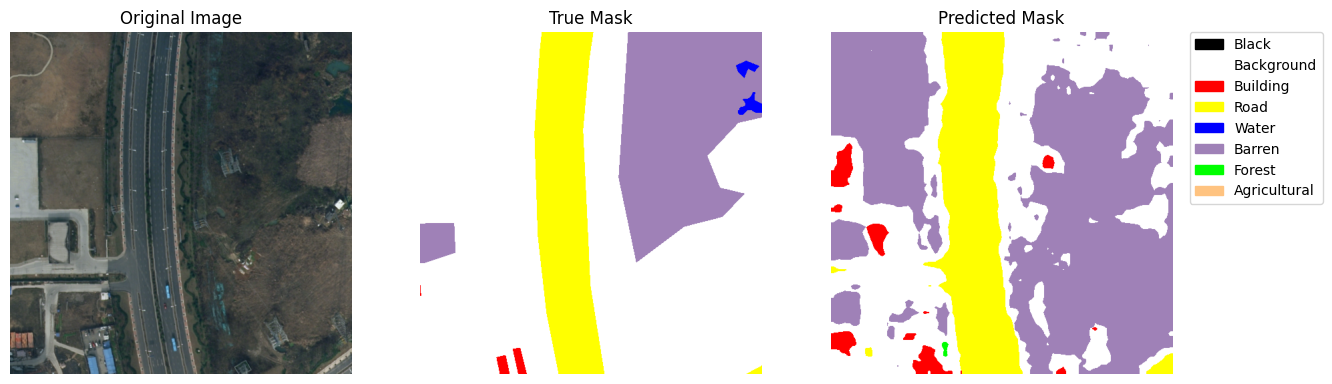

Epoch 14/20: 100%|██████████| 1152/1152 [02:44<00:00,  7.00it/s, Loss_G=0.5888, Loss_D=0.3620]


Epoch 14, Average Loss_G: 0.6213, Average Loss_D: 0.4155


IoU per category (%):
 Background: 40.48%
 Building: 20.70%
 Road: 19.11%
 Water: 31.80%
 Barren: 5.70%
 Forest: 4.10%
 Agricultural: 12.06%

mIoU: 19.13%

Validation mIoU after epoch 14: 0.1913
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  2  4  5]
Unique values in predicted mask: [0 1 2 3 4 5 6]



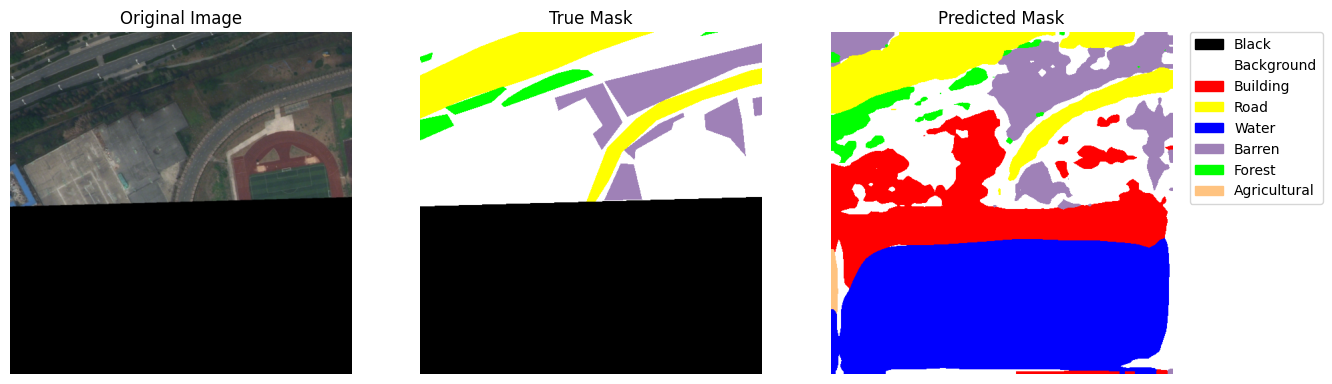

Epoch 15/20: 100%|██████████| 1152/1152 [02:42<00:00,  7.11it/s, Loss_G=0.6181, Loss_D=0.4247]


Epoch 15, Average Loss_G: 0.6375, Average Loss_D: 0.4285


IoU per category (%):
 Background: 40.13%
 Building: 20.90%
 Road: 19.22%
 Water: 33.75%
 Barren: 5.73%
 Forest: 3.58%
 Agricultural: 12.04%

mIoU: 19.34%

Validation mIoU after epoch 15: 0.1934
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5 6]
Unique values in predicted mask: [0 1 2 4 5]



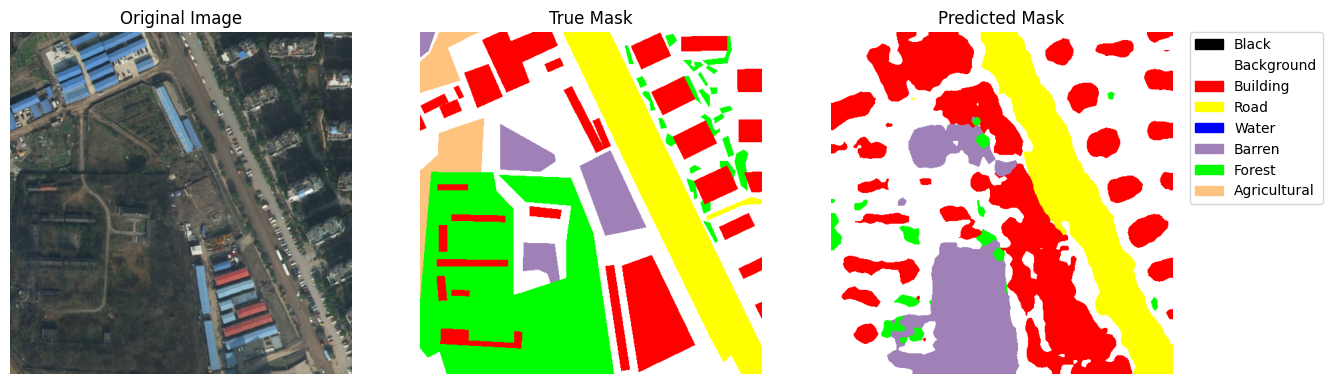

Epoch 16/20: 100%|██████████| 1152/1152 [02:41<00:00,  7.13it/s, Loss_G=0.5342, Loss_D=0.4651]


Epoch 16, Average Loss_G: 0.6340, Average Loss_D: 0.3958


IoU per category (%):
 Background: 39.82%
 Building: 21.75%
 Road: 19.34%
 Water: 31.58%
 Barren: 5.73%
 Forest: 4.06%
 Agricultural: 12.80%

mIoU: 19.30%

Validation mIoU after epoch 16: 0.1930
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5 6]
Unique values in predicted mask: [0 1 2 4 5]



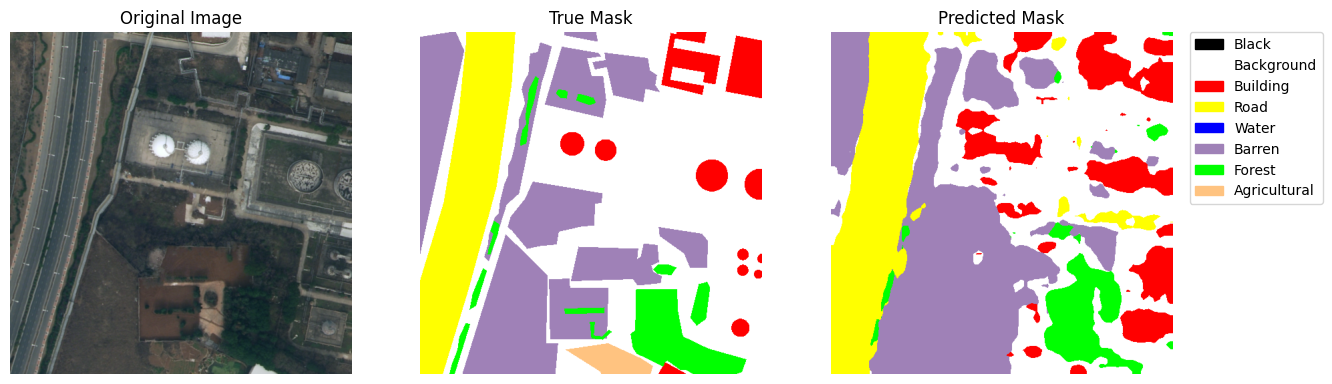

Epoch 17/20: 100%|██████████| 1152/1152 [02:43<00:00,  7.04it/s, Loss_G=0.5955, Loss_D=0.4604]


Epoch 17, Average Loss_G: 0.6409, Average Loss_D: 0.3709


IoU per category (%):
 Background: 40.56%
 Building: 22.25%
 Road: 19.52%
 Water: 32.82%
 Barren: 5.83%
 Forest: 3.97%
 Agricultural: 13.55%

mIoU: 19.79%

Validation mIoU after epoch 17: 0.1979
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 4 5 6]
Unique values in predicted mask: [0 1 2 4 5]



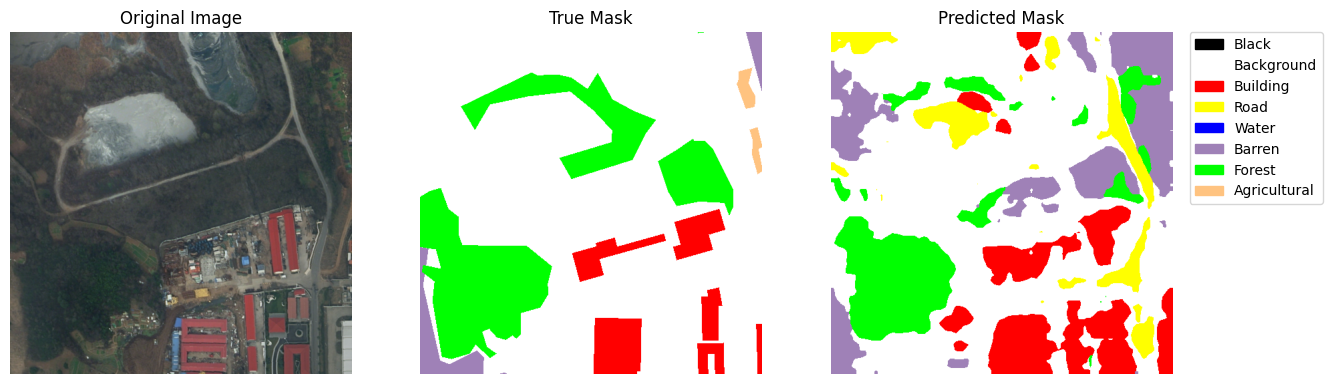

Epoch 18/20: 100%|██████████| 1152/1152 [02:45<00:00,  6.96it/s, Loss_G=0.6598, Loss_D=0.3859]


Epoch 18, Average Loss_G: 0.6478, Average Loss_D: 0.3289


IoU per category (%):
 Background: 40.17%
 Building: 20.34%
 Road: 19.24%
 Water: 31.09%
 Barren: 5.88%
 Forest: 3.36%
 Agricultural: 12.01%

mIoU: 18.87%

Validation mIoU after epoch 18: 0.1887
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



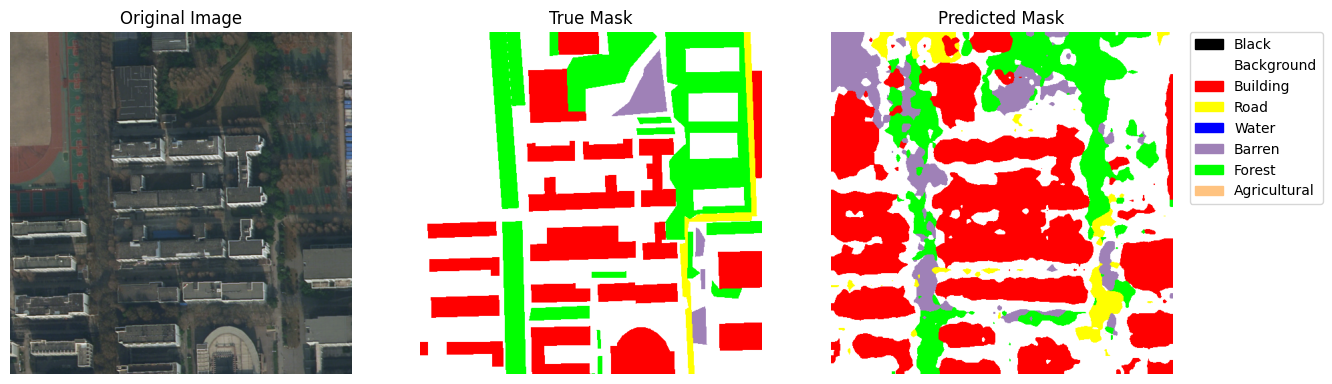

Epoch 19/20: 100%|██████████| 1152/1152 [02:44<00:00,  7.02it/s, Loss_G=0.7496, Loss_D=0.3775]


Epoch 19, Average Loss_G: 0.6613, Average Loss_D: 0.3026


IoU per category (%):
 Background: 39.65%
 Building: 21.54%
 Road: 19.38%
 Water: 33.24%
 Barren: 5.50%
 Forest: 3.96%
 Agricultural: 12.34%

mIoU: 19.37%

Validation mIoU after epoch 19: 0.1937
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 5]
Unique values in predicted mask: [0 1 2 3 5]



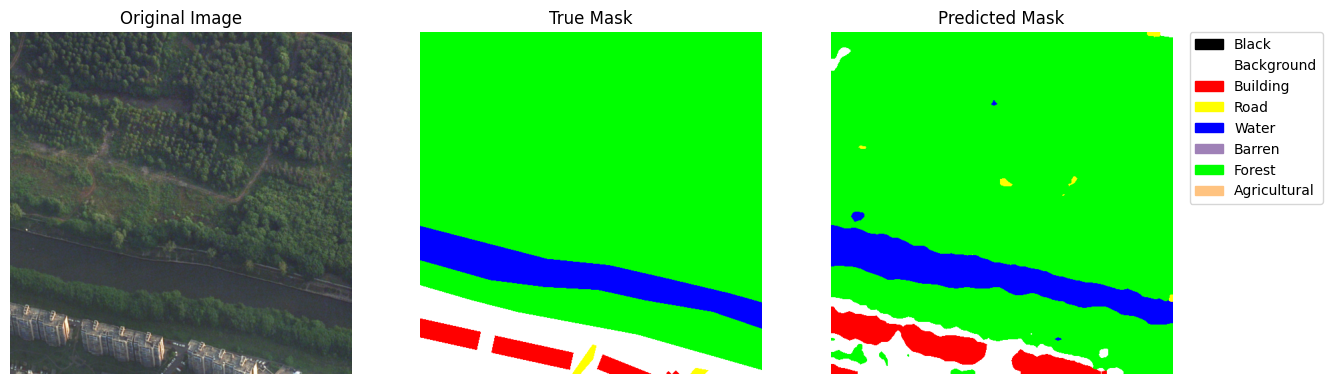

Epoch 20/20: 100%|██████████| 1152/1152 [02:45<00:00,  6.96it/s, Loss_G=0.6879, Loss_D=0.1743]


Epoch 20, Average Loss_G: 0.6697, Average Loss_D: 0.2785


IoU per category (%):
 Background: 39.91%
 Building: 21.32%
 Road: 19.26%
 Water: 31.50%
 Barren: 5.51%
 Forest: 3.81%
 Agricultural: 12.10%

mIoU: 19.06%

Validation mIoU after epoch 20: 0.1906
Comparing true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 5]
Unique values in predicted mask: [0 1 2 5]



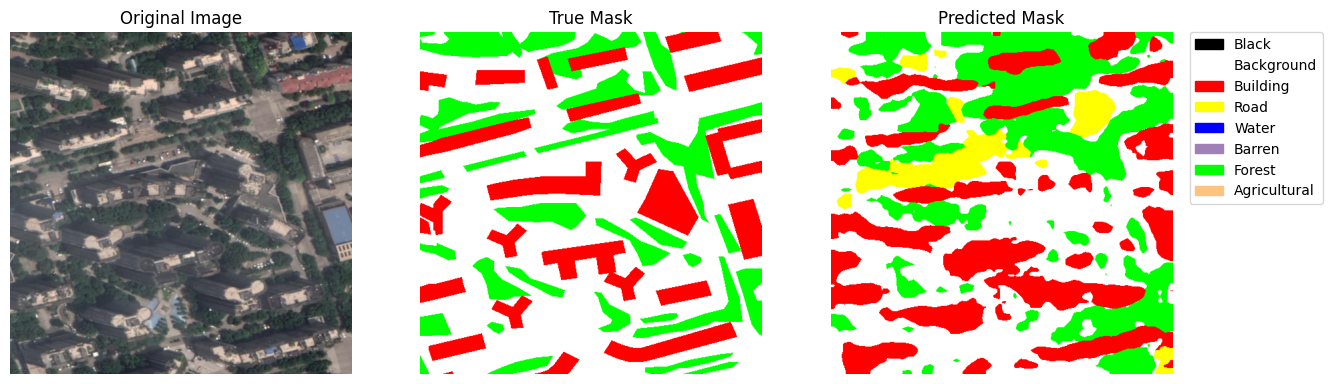

In [ ]:
# Scheduler for the generator
def poly_lr_scheduler(optimizer, init_lr, iter, max_iter, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Storici per il monitoraggio
lr_history = []
lr_d_history = []
miou_history = []

best_miou = 0.0  # Initialize best mIoU

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# Set the generator scheduler to MultiStepLR
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=STEP_SIZE, gamma=GAMMA)

# Initializing discriminators
model_D = FCDiscriminator(num_classes=NUM_CLASSES).to(device)
optimizer_D = torch.optim.AdamW(model_D.parameters(), lr=LR_D, betas=(0.9, 0.99), weight_decay=WEIGHT_DECAY_DISC)

# Loss functions
loss_func_G = nn.CrossEntropyLoss(weight = weights, ignore_index=-1)
loss_func_D = nn.BCEWithLogitsLoss()
loss_func_adv = nn.BCEWithLogitsLoss()

# Labels for the discriminator
source_label = 0
target_label = 1

# GradScaler for mixed precision
scaler = torch.amp.GradScaler()

global_iter = 0  # Global counter for training

augmentations = DataAugmentation(probability=0.5)

if trained == False:
    # Training loop
  for epoch in range(NUM_EPOCHS):
      model.train()
      model_D.train()

      ###
      total_loss_G = 0.0
      total_loss_D = 0.0

      tq = tqdm(total=len(train_loader_source) * train_loader_source.batch_size)
      tq.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}")

      for param in model_D.parameters():
          param.requires_grad = False  # Freezes gradients for the discriminator

      for i, (source_data, target_data) in enumerate(zip(train_loader_source, train_loader_target)):
          source_images, source_labels = source_data
          target_images, _ = target_data

          source_images, source_labels = source_images.to(device), source_labels.to(device)
          target_images = target_images.to(device)

          # Apply data augmentation
          augmented_source_images = []
          augmented_source_labels = []
          augmented_target_images = []
          for img, label in zip(source_images, source_labels):
              aug_img, aug_label = augmentations(img, label)
              augmented_source_images.append(aug_img)
              augmented_source_labels.append(aug_label)
          # Directly augment the batch of target images
          for img in target_images:
              aug_img, _ = augmentations(img, torch.zeros(img.size(0), img.size(1), img.size(2)))
              augmented_target_images.append(aug_img)
          # Convert lists into tensors
          source_images = torch.stack(augmented_source_images).to(device)
          source_labels = torch.stack(augmented_source_labels).to(device)
          target_images = torch.stack(augmented_target_images).to(device)


          # Optimizing the main model
          optimizer.zero_grad()
          with torch.cuda.amp.autocast():
              # Forward pass for source domain
              source_output = model(source_images)
              source_output_rescaled = torch.nn.functional.interpolate(source_output, size=(512, 512), mode='bilinear', align_corners=False)
              loss_seg = loss_func_G(source_output_rescaled, source_labels)

              # Forward pass for target domain
              target_output = model(target_images)
              D_out = model_D(F.softmax(target_output, dim=1))

              # Adversarial loss calculation
              loss_adv = loss_func_adv(
                  D_out, torch.full(D_out.size(), source_label, device=device, dtype=torch.float32)
              ) * LAMBDA_ADV

              # Total loss for the main model
              loss_G = loss_seg + loss_adv

          scaler.scale(loss_G).backward()
          scaler.step(optimizer)
          scaler.update()

          ###
          total_loss_G += loss_G.item()

          # Discriminator optimization
          for param in model_D.parameters():
              param.requires_grad = True

          optimizer_D.zero_grad()
          with torch.cuda.amp.autocast():
              # Discriminator loss for source domain
              D_out_source = model_D(F.softmax(source_output.detach(), dim=1))
              loss_D_source = loss_func_D(
                  D_out_source, torch.full(D_out_source.size(), source_label, device=device, dtype=torch.float32)
              )

              # Discriminator loss for target domain
              D_out_target = model_D(F.softmax(target_output.detach(), dim=1))
              loss_D_target = loss_func_D(
                  D_out_target, torch.full(D_out_target.size(), target_label, device=device, dtype=torch.float32)
              )

              # Total discriminator loss
              loss_D = (loss_D_source + loss_D_target) / 2

          scaler.scale(loss_D).backward()
          scaler.step(optimizer_D)
          scaler.update()
          ###
          total_loss_D += loss_D.item()

          lr_d = poly_lr_scheduler(optimizer_D, init_lr=LR_D, iter=global_iter, max_iter=len(train_loader_source) * NUM_EPOCHS)
          lr_d_history.append(lr_d)

          global_iter += 1

          tq.set_postfix({
              "Loss_G": f"{loss_G.item():.4f}",
              "Loss_D": f"{loss_D.item():.4f}"
          })
          tq.update(train_loader_source.batch_size)

      # Increment LAMBDA_ADV
      LAMBDA_ADV = min(LAMBDA_ADV + LAMBDA_ADV_STEP, LAMBDA_ADV_MAX)

      # Aggiornare il learning rate con lo scheduler MultiStepLR per il generatore
      scheduler.step()  # Questo aggiorna il learning rate per il generatore
      lr = optimizer.param_groups[0]['lr']
      lr_history.append(lr)

      tq.close()
      print()
      print(f"Epoch {epoch + 1}, Average Loss_G: {total_loss_G / len(train_loader_source):.4f}, Average Loss_D: {total_loss_D / len(train_loader_target):.4f}")

      # Validation every N epochs
      model.eval()
      mIoU = compute_mIoU(model, val_loader, num_classes=NUM_CLASSES, device=device)
      miou_history.append(mIoU)  # Update miou_history
      print(f"Validation mIoU after epoch {epoch + 1}: {mIoU:.4f}")

      # Save the best model
      if mIoU > best_miou:
          best_miou = mIoU
          torch.save(model.state_dict(), f"best_model_adversarial_optWL_multiStepLR.pth")
          print(f"New best model saved with mIoU: {best_miou:.4f}")

      # Prediction visualization
      model.eval()
      sample_image, sample_label = next(iter(train_loader_source))
      sample_image, sample_label = sample_image[0].to(device), sample_label[0].to(device)

      with torch.no_grad():
          pred_mask = model(sample_image.unsqueeze(0))
          pred_mask_resized = torch.nn.functional.interpolate(pred_mask, size=(512, 512), mode='bilinear')
          pred_mask = pred_mask_resized.argmax(dim=1).squeeze(0)

      visualize_prediction(sample_image, sample_label, pred_mask)
      trained = True
      plot_training = True
else:
  print("Model already trained")
  model.load_state_dict(torch.load("/content/best_model_adversarial_optWL_multiStepLR.pth", weights_only=True))
  model.to(device)


# **Results**

In [ ]:
model.load_state_dict(torch.load("/content/best_model_adversarial_optWL_multiStepLR.pth", weights_only=True))
model.to(device)
# mIoU
mIoU = compute_mIoU(model, val_loader, num_classes=NUM_CLASSES, device=device)

IoU per category (%):
 Background: 42.49%
 Building: 20.35%
 Road: 24.55%
 Water: 32.26%
 Barren: 7.62%
 Forest: 7.62%
 Agricultural: 21.82%

mIoU: 22.39%



## Final graph

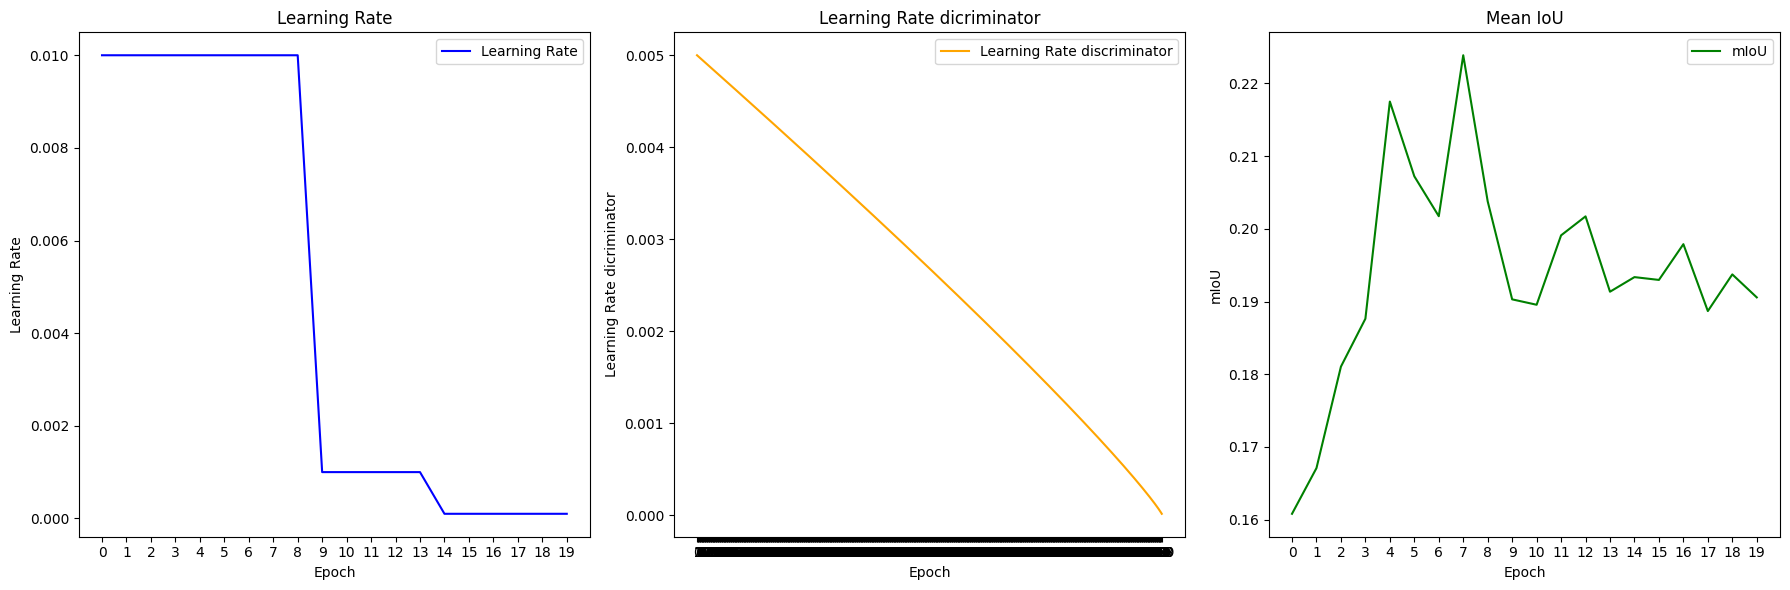

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(lr_history, lr_d_history, miou_history):
    """
    Function to plot the graph of loss, learning rate and mIoU.

    Parameters:
    - loss_history: list containing the loss values ​​for each epoch.
    - lr_history: list containing the learning rate values ​​for each epoch.
    - miou_history: list containing the mIoU values ​​calculated every 5 epochs.
    """
    plt.figure(figsize=(18, 6))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(lr_history, label='Learning Rate', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    plt.legend()
    plt.xticks(range(len(lr_history)))

    # Learning Rate plot
    plt.subplot(1, 3, 2)
    plt.plot(lr_d_history, label='Learning Rate discriminator', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate dicriminator')
    plt.title('Learning Rate dicriminator')
    plt.legend()
    plt.xticks(range(len(lr_d_history)))

    # mIoU plot
    plt.subplot(1, 3, 3)
    plt.plot(miou_history, label='mIoU', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.title('Mean IoU')
    plt.legend()
    plt.xticks(range(len(miou_history)))

    plt.tight_layout()
    plt.show()

if plot_training:
  plot_training_metrics(lr_history, lr_d_history, miou_history)